In [2]:
# imports
# for preprocessing
import nltk
from nltk import FreqDist
# nltk.download('stopwords') # run this one time
from nltk.corpus import stopwords
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import json
import numpy as np
import re
import spacy
# for building the model and its required components (dictionary, dtm..)
import gensim
from gensim import corpora
# for visualizing the LDA output as well as the word frequencies
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
# read data and print some of the data
jobs_df = pd.read_json('data/all-jobs.json')
jobs_df.head(3)
# print(len(jobs_df))


company               emp_type  \
0      Netfort     Permanent full-time    
1      Experis                Contract    
2    The Panel                Contract    

                                                                                                                                                                                                 full_desc  \
0    Description NetFort are currently recruiting for Senior Software Engineers to join our team in Galway. \xc2\xa0 DESCRIPTIONAt NetFort, we design and develop software that analyzes network traffi...   
1    Description Passenger Service Systems (PSS) Solution Architect required for contract position in Dublin North. Must have Airline Industry experience. \xc2\xa0  Passenger Service Systems (PSS) So...   
2    Description Lead Business Analyst \xc2\xa0 Lead Business AnalystContract \xe2\x80\x93 6 monthsWe are looking for a Lead Business Analyst to work within the Business Change area of the Core Banki...   

   id          location             salary  \
0   1          Galway          Negotiable    
1   2    Dublin North     See description    
2   3          Dublin          Negotiable    

                                                                                                                                      short_desc  \
0                                                   NetFort are currently recruiting for Senior Software Engineers to join our team in Galway.     
1    Passenger Service Systems (PSS) Solution Architect required for contract position in Dublin North. Must have Airline Industry experience.     
2                                                                                                                        Lead Business Analyst     

                                               title               updated  \
0                        Senior Software Engineers     Updated 14/12/2018    
1   Passenger Service Systems - Solution Architect     Updated 16/12/2018    
2                  Lead Business Analyst - Banking     Updated 16/12/2018    

                                                                 url  
0                      /Jobs/Senior-Software-Engineers-8264931.aspx   
1   /Jobs/Passenger-Service-Systems-Solution-Architect-8259810.aspx   
2                  /Jobs/Lead-Business-Analyst-Banking-8265025.aspx

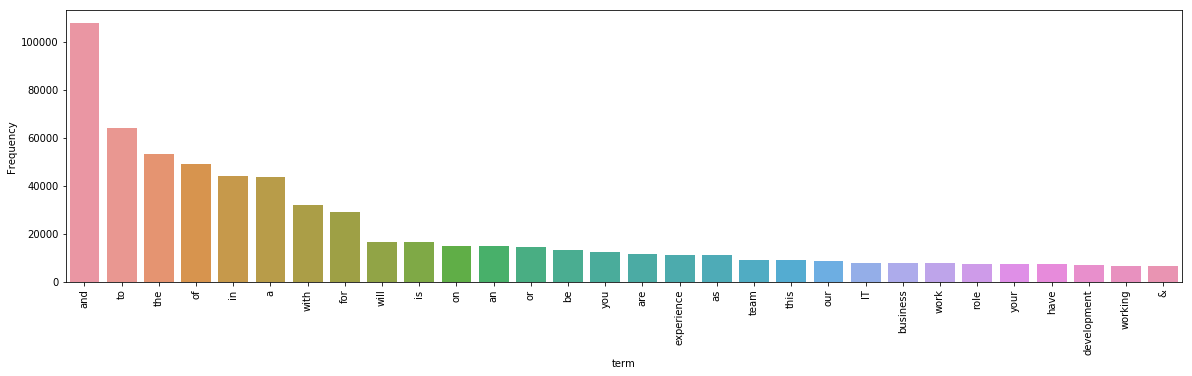

In [4]:
# This function plots the most frequent terms occuring in descriptions
# It does the count by joining all descriptions into one string, splitting the words into separate line and counting like that. 
def freq_terms(descriptions, terms = 30):
    all_terms = ' '.join([desc for desc in descriptions])
    all_terms = all_terms.split()
    freq_dist = FreqDist(all_terms)
    terms_df = pd.DataFrame({'term':list(freq_dist.keys()), 'frequency':list(freq_dist.values())})
    # choose top 20 terms 
    d = terms_df.nlargest(columns='frequency', n = terms)
    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=90)
    ax = sns.barplot(data=d, x = 'term', y = 'frequency')
    ax.set(ylabel = 'Frequency')
    plt.show()
    
freq_terms(jobs_df['full_desc'])



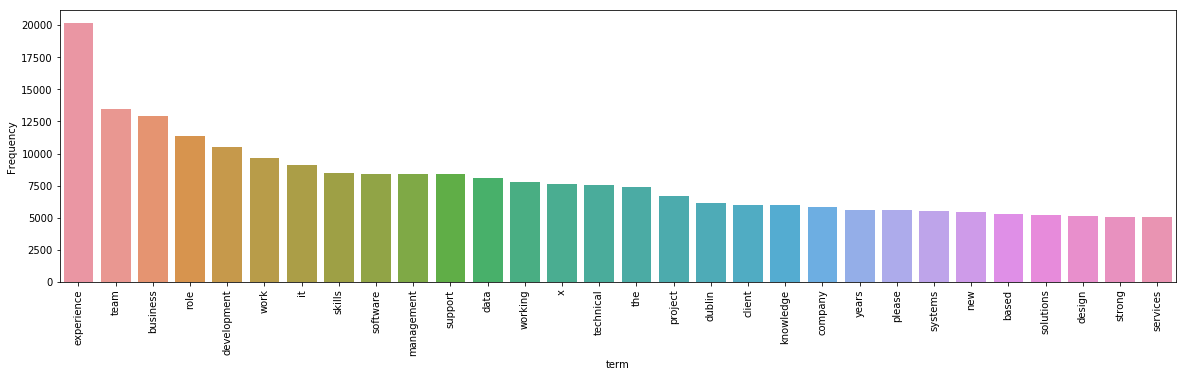

In [5]:
# Preprocessing the texts.
###########################################################################################################

# identify stopwords dictionary
stop_words = stopwords.words('english')
# function for removing stopwords 
def rm_stopwords(desc):
    desc_new = ' '.join([i for i in desc if i not in stop_words])
    return desc_new

# # remove unwanted terms
# unwanted_terms = ['experience', 'requirement', 'year', 'new', 'work', 'job', 'company', 'Description', 'that', 'people' ]            
# def remove_unwanted_words(desc):
#     desc_new = ' '.join([i for i in desc if i not in unwanted_terms])
    
#     return desc_new

#remove short words with length of less than 3.
# jobs_df['full_desc'] = jobs_df['full_desc'].apply(lambda x: ' '.join([t for t in x.split() if len(t)>2]))

# remove specific frequent terms.
jobs_df['full_desc'] = jobs_df['full_desc'].str.replace('xa','').str.replace('xc', '').str.replace('xe','').str.replace(' x ', '')

# remove unwanted characters, numbers and symbols
jobs_df['full_desc'] = jobs_df['full_desc'].str.replace("[^a-zA-Z#]", " ")

# remove the stopwords
descriptions = [rm_stopwords(d.split()) for d in jobs_df['full_desc']]

# make descriptions lowercase
descriptions = [d.lower() for d in descriptions] # check description[0]

# plot 
freq_terms(descriptions)


In [6]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################





In [7]:
# We still have neutral terms like ‘the’, ‘this’, ‘much’, ‘they’ which are not that relevant.
# To further remove noise from the text we can use lemmatization from the spaCy library. 
# It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatize(descs, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in descs:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

# tokenize the descs, then lemmatize them.
tok_descs = pd.Series(descriptions).apply(lambda x: x.split())

# apply lemmatizing function
descriptions2 = lemmatize(tok_descs) 


print('Before lemmatization:\n=======================\n', tok_descs[0])
# type(tok_descs)


print('After lemmatization:\n=======================\n', descriptions2[0])
# Words are lemmatized and nouns/adj are removed from the descriptions. 




Before lemmatization:
 ['description', 'netfort', 'currently', 'recruiting', 'senior', 'software', 'engineers', 'join', 'team', 'galway', 'descriptionat', 'netfort', 'design', 'develop', 'software', 'analyzes', 'network', 'traffic', 'using', 'deep', 'packet', 'inspection', 'techniques', 'give', 'customers', 'unique', 'level', 'internal', 'visibility', 'including', 'user', 'activity', 'file', 'database', 'monitoring', 'intrusion', 'detection', 'bandwidth', 'usage', 'internet', 'access', 'we', 'located', 'galway', 'great', 'cultural', 'sporting', 'city', 'one', 'fastest', 'growing', 'cities', 'europe', 'our', 'engineers', 'work', 'core', 'r', 'd', 'projects', 'requirements', 'capture', 'analysis', 'design', 'coding', 'deployment', 'support', 'as', 'senior', 'software', 'engineer', 'involved', 'following', 'lifecycle', 'activities', 'x', 'software', 'architecture', 'detailed', 'design', 'helping', 'interpret', 'analyze', 'requirements', 'x', 'software', 'development', 'written', 'technica

0    description netfort senior software engineer team galway netfort design software network traffic deep packet inspection technique customer unique level internal visibility user activity file datab...
1    description passenger service system solution architect contract position dublin north airline industry experience passenger service system solution architectcontractnegotiabledublin north locatio...
2    description lead business analyst lead business analystcontract monthswe lead business analyst work business change area core banking system programme ideal candidate experience t module tfs provi...
Name: full_desc, dtype: object


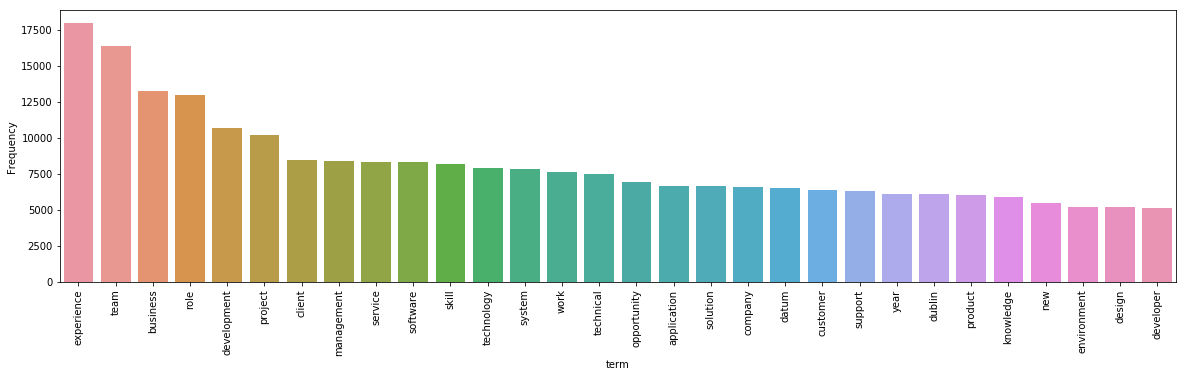

In [8]:
# Now join all tokens together in one string for each dictionary
descriptions3 = []
for i in range(len(descriptions2)):
    descriptions3.append(' '.join(descriptions2[i]))

# put it back into df
jobs_df['full_desc'] = descriptions3

# print few samples
print(jobs_df['full_desc'][:3])

# visualize the frequent terms now. 
freq_terms(jobs_df['full_desc'])

In [9]:
# We are almost ready to build the LDA model. We just need 2 more things:
#
# 1. Dictionary - comprised of all unique values from all job descriptions and each of them have an index assigned.
# 2. Remove some more of the unwanted terms that appear frequently and do not have much value.
# 3. Create a corpus from Document term matrix comprised of bags of words.

# dictionary
dictionary = corpora.Dictionary(descriptions2)
print(dictionary)
# save dictionary
dictionary.save('data/dictionary.dict')

# remove bad terms
# these terms were seen in the final LDA output and I decided to remove them to see the result
bad_terms = ['-PRON-', 'experience', 'requirement', 'year', 'new', 'work', 'job', 'company', 'description', 'that', 'people', 'client', 'opportunity',
             'role', 'great', 'financial']
for bad_term in bad_terms:
    dictionary.filter_tokens(bad_ids=[dictionary.token2id[bad_term]])
# check if terms were deleted
print('-PRON- in dictionary?: ' in dictionary.token2id)

# Create a DTM corpus
corpus_dtm = [dictionary.doc2bow(desc) for desc in descriptions2]
print(corpus_dtm)
# save corpus
with open('data/corpus_dtm.json', 'w') as outfile:
    json.dump(corpus_dtm, outfile)
    


Dictionary(27490 unique tokens: ['-PRON-', 'access', 'activity', 'analysis', 'analyze']...)
False


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# Now we have everything ready for our LDA model.
# Define LDA object 
LDA = gensim.models.ldamodel.LdaModel
# Build the LDA model using our dictionary and corpus_dtm.
model_lda = LDA(corpus=corpus_dtm, id2word=dictionary, num_topics=40, random_state=100,
                chunksize=1000, passes=50)


print(model_lda.print_topics())

[(34, '0.041*"system" + 0.022*"investigate" + 0.021*"report" + 0.019*"control" + 0.016*"team" + 0.015*"quality" + 0.015*"sector" + 0.014*"form" + 0.014*"real" + 0.013*"accurate"'), (7, '0.061*"similar" + 0.044*"discuss" + 0.037*"contract" + 0.035*"rate" + 0.034*"daily" + 0.029*"permanent" + 0.026*"touch" + 0.025*"dublin" + 0.025*"discussion" + 0.024*"confidential"'), (19, '0.073*"email" + 0.057*"request" + 0.051*"confidential" + 0.038*"position" + 0.038*"information" + 0.029*"recruit" + 0.028*"qualification" + 0.028*"contact" + 0.024*"relevant" + 0.023*"hospital"'), (10, '0.142*"test" + 0.065*"automation" + 0.063*"testing" + 0.031*"software" + 0.026*"quality" + 0.020*"team" + 0.020*"engineer" + 0.014*"tool" + 0.013*"qa" + 0.012*"development"'), (17, '0.082*"investment" + 0.058*"graduate" + 0.030*"cash" + 0.029*"credit" + 0.026*"programme" + 0.025*"possibility" + 0.024*"collection" + 0.022*"trade" + 0.015*"fid" + 0.014*"trading"'), (12, '0.047*"team" + 0.040*"software" + 0.026*"developm

In [11]:
# Save model the produced model. 
from gensim.test.utils import datapath
# model_file = datapath("40_it_topics.gensim")
# model_lda.save(model_file)

# Finally, visualize produced topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_lda, corpus_dtm, dictionary)
vis





c:\users\atha\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.205316  0.057410       1        1  10.335002
3      0.173679  0.028982       2        1   7.181278
12     0.151421 -0.000400       3        1   7.134476
29     0.193053  0.109922       4        1   6.462157
15     0.083466 -0.245095       5        1   5.164721
23     0.160651  0.079850       6        1   4.943977
26     0.139226  0.007363       7        1   4.390214
18     0.128050 -0.008504       8        1   4.052867
24     0.140072  0.028975       9        1   3.435779
5      0.109827  0.041186      10        1   3.288668
13     0.096678 -0.114879      11        1   3.114887
4      0.142084  0.148127      12        1   3.080833
37     0.087273  0.046433      13        1   3.079929
34     0.096370 -0.007146      14        1   3.072522
10     0.116178  0.161287      15        1   2.502045
6      0.037486  0.015809      16        1   2.451339
14     0.084451  0.058213      17        1   2.313216
7     -0.015260 -0.225421      18        1   2.219133
31     0.069747  0.061459      19        1   2.156912
33     0.071706  0.081214      20        1   2.031616
36     0.029215 -0.107119      21        1   1.766054
16     0.046741  0.109220      22        1   1.676592
9      0.058094 -0.067142      23        1   1.619256
0     -0.026241 -0.124022      24        1   1.405182
39    -0.074185 -0.180387      25        1   1.351917
28    -0.031049 -0.219721      26        1   1.346336
38    -0.006895 -0.034000      27        1   1.328571
35    -0.023971 -0.166704      28        1   1.325650
22    -0.013144  0.017316      29        1   1.051312
20    -0.044494  0.034251      30        1   0.958596
32    -0.039889  0.076489      31        1   0.768688
25    -0.081260 -0.055213      32        1   0.709485
21    -0.093014 -0.010860      33        1   0.682834
27    -0.175909  0.097914      34        1   0.416490
19    -0.262140 -0.040810      35        1   0.318448
17    -0.277462  0.041260      36        1   0.268241
1     -0.311686  0.082438      37        1   0.240092
30    -0.237890  0.050398      38        1   0.237648
2     -0.347658  0.080283      39        1   0.080896
11    -0.358636  0.091624      40        1   0.036136, topic_info=      Category        Freq                                         Term  \
term                                                                      
403    Default   6169.0000                                      product   
214    Default   6673.0000                                        datum   
320    Default   4391.0000                                     security   
112    Default  13599.0000                                     business   
428    Default   3769.0000                                         test   
71     Default  10404.0000                                      project   
458    Default   5312.0000                                    developer   
395    Default   2939.0000                                          net   
20     Default   6474.0000                                     customer   
88     Default   6459.0000                                      support   
82     Default   8572.0000                                     software   
27     Default  10975.0000                                  development   
83     Default   6707.0000                                     solution   
91     Default   7755.0000                                    technical   
142    Default   8591.0000                                      service   
24     Default   5205.0000                                       design   
89     Default   7979.0000                                       system   
7      Default   2241.0000                                            c   
259    Default   4292.0000                                  information   
120    Default   6286.0000                                       dublin   
1207   Default   1453.0000             

In [4]:
# Topic nrs selected from the chart -- 3,4,5,7,8,13,14,15,16,18,19,23,29

# Loading the model
import gensim
from gensim.test.utils import datapath
LDA = gensim.models.ldamodel.LdaModel
lda_40 = LDA.load(datapath("40_it_topics.gensim"))

print('Number of topics: -- ', lda_40.num_topics)
lda_40.show_topics(num_topics=40, num_words=30)[0]

# the order of the topics is different when printing out. 
# it seems like now I need to compare the output bellow with visualized topics and write a new list of topics that I need.
# that is -- 22,33,2,25,32,17,34,35,36,24,12,16,18






Number of topics: --  40


NameError: name 'corpus_dtm' is not defined

In [15]:
# load corpus
corpus_dtm = open('data/corpus_dtm.json')
corpus_dtm = json.load(corpus_dtm)

# load dictionary
dictionary = gensim.corpora.Dictionary.load('data/dictionary.dict')

# Visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_40, corpus_dtm, dictionary)
vis
pyLDAvis.save_html(vis,'40topics_vis.html')

c:\users\atha\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.169781  0.012441       1        1  13.295794
4      0.171218  0.029759       2        1  10.339074
34     0.112395 -0.180342       3        1   6.547276
22     0.145528 -0.164524       4        1   6.061289
39     0.080114  0.076848       5        1   5.592906
33     0.169171 -0.101755       6        1   5.335492
17     0.118955 -0.187269       7        1   5.173966
27     0.085079  0.108519       8        1   5.060902
32     0.102084  0.103274       9        1   4.254282
35     0.101214 -0.150914      10        1   3.351278
25     0.121891 -0.006278      11        1   3.312753
0      0.101977  0.049519      12        1   2.895268
1     -0.028206  0.112184      13        1   2.363222
14     0.074233 -0.049080      14        1   2.327458
13     0.039423  0.028391      15        1   2.140170
7      0.048464  0.086247      16        1   1.919357
2      0.151225  0.063145      17        1   1.644158
9     -0.004444  0.086217      18        1   1.438142
3      0.089327  0.097914      19        1   1.400530
12     0.006712 -0.062241      20        1   1.382253
24     0.098879 -0.124073      21        1   1.365192
18    -0.095593 -0.073430      22        1   1.262106
15    -0.154890 -0.002450      23        1   1.246756
36     0.085047 -0.187065      24        1   1.093381
26    -0.034737  0.089749      25        1   1.013448
6     -0.045358  0.104993      26        1   0.959941
16    -0.052620  0.035947      27        1   0.813608
23    -0.050708  0.093923      28        1   0.797500
37     0.001864  0.029765      29        1   0.787619
28    -0.236148 -0.014022      30        1   0.743385
5      0.037918  0.213878      31        1   0.727338
19     0.016144 -0.007647      32        1   0.669959
31    -0.081520  0.108169      33        1   0.630058
20    -0.125689 -0.180636      34        1   0.477904
21    -0.365799 -0.070096      35        1   0.477403
38     0.025399 -0.043509      36        1   0.442230
10    -0.057549  0.151473      37        1   0.321365
11    -0.115245  0.053532      38        1   0.169771
29    -0.346899 -0.070841      39        1   0.093973
30    -0.358640 -0.059717      40        1   0.071492, topic_info=      Category          Freq                 Term         Total  loglift  \
term                                                                       
110    Default  12070.000000              writing  12070.000000  30.0000   
425    Default   6194.000000               runner   6194.000000  29.0000   
81     Default   8937.000000               salary   8937.000000  28.0000   
210    Default   4180.000000                 call   4180.000000  27.0000   
26     Default  10902.000000               design  10902.000000  26.0000   
70     Default   5699.000000               player   5699.000000  25.0000   
400    Default   4416.000000              library   4416.000000  24.0000   
455    Default   3916.000000                 amqp   3916.000000  23.0000   
316    Default   2571.000000              program   2571.000000  22.0000   
89     Default  17359.000000           specialist  17359.000000  21.0000   
88     Default   9629.000000             solution   9629.000000  20.0000   
58     Default   2688.000000            lifecycle   2688.000000  19.0000   
128    Default   8422.000000           governance   8422.000000  18.0000   
31     Default   6119.000000              dynamic   6119.000000  17.0000   
377    Default   2999.000000              desktop   2999.000000  16.0000   
19     Default   5509.000000         criteriaunix   5509.000000  15.0000   
187    Default   7102.000000             validate   7102.000000  14.0000   
82     Default   6847.000000                scale   6847.000000  13.0000   
191    Default   3757.000000         accomplished   3757.000000  12.0000   
92     Default   9255.000000             standard   9255.000000  11.0000   
87     Default   

In [32]:
# NOW ... the LDA output has all the values that we need but there is a lot of characters that needs to be removed, in order to make use those values. 
# first we will start by creating a list of all topics
topics= []
# for every topic append the contents into the topics list
show_tpcs = lda_40.show_topics(num_topics=40, num_words=30, log=False, formatted=True)
for i in range(len(show_tpcs)):
    topics.append(show_tpcs[i])
#     print(show_tpcs[i])
print('Length of topics list: ', len(topics))

# Clean the output and populate new list with filtered string values
clean_topics =[]
for topic in topics:
    # Remove confusing characters in each topic
    topic = str(topic)
    topic = topic.replace('*', '').replace('+', '')
    topic = topic.replace('" ', ',').replace('"', ',').replace('(', '').replace(')', '')
    topic = topic.replace(",'", "").replace("'", "").replace(',', ' ')
    # add to new list
    clean_topics.append(topic)
print('Sample of clean topics:\n=============\n', clean_topics[0])
print('Length of clean topics: ', len(clean_topics))
    
# Create a list of topics as dictionaries --- containing topic number and corresponding terms within the topic
lda_dicts = []
for i in range(len(clean_topics)):
    lda_dict = {}
    lda_dict['topic_nr'] = i    
    # terms
    terms = []
    for val in clean_topics[i].split():
        if val.isdigit() == False and '0.' not in val:
            terms.append(val)
#     print('\nTerms in topic ', i,':\n===================\n',terms)
    lda_dict['terms'] = terms
    lda_dicts.append(lda_dict)
print(lda_dicts)

print('\n\nThe LDA is now being written to json...')
# write the terms into json.
with open('data/lda_40_topics.json', 'w') as f:  # writing JSON object
    json.dump(lda_dicts, f)
    
    
    
 

Length of topics list:  40
Sample of clean topics:
 0  0.136 business  0.080 analyst  0.029 system  0.029 analysis  0.024 process  0.011 management  0.010 investment  0.010 eel  0.010 key  0.009 risk  0.009 solution  0.009 stakeholder  0.009 candidate  0.008 information  0.008 project  0.008 fund  0.008 banking  0.008 insurance  0.007 team  0.007 user  0.007 knowledge  0.006 change  0.006 area  0.006 model  0.006 document  0.006 functional  0.005 regulatory  0.005 understanding  0.005 finance  0.005 skill
Length of clean topics:  40
[{'topic_nr': 0, 'terms': ['business', 'analyst', 'system', 'analysis', 'process', 'management', 'investment', 'eel', 'key', 'risk', 'solution', 'stakeholder', 'candidate', 'information', 'project', 'fund', 'banking', 'insurance', 'team', 'user', 'knowledge', 'change', 'area', 'model', 'document', 'functional', 'regulatory', 'understanding', 'finance', 'skill']}, {'topic_nr': 1, 'terms': ['payment', 'service', 'knowledge', 'technical', 'technology', 'intern